# machine learning: cifar10 group project

## import everything to run the jupyer notebook

- import missing packages 
- download and install packages which are requiert and not installed

In [26]:
import os
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import genfromtxt
from keras import regularizers
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import load_model
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

%matplotlib inline

## helper functions global variabels to run the jupyter notebook

In [2]:
# cifar10 category label name
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

# function which ....TODO
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

## get the  dataset and do further preprocessing steps


- download the cifar10 dataset ffrom the offical keras/ tensorflow package repository
- prepare the test and trainingsdata so that ...TODO


### NOTE:

_The values in the ndarrays here are already preprocessed.
So, the requierenments on the shape of the input data is fullfilled.
The requierenments are determineded by the the fit function from the keras conv layer_


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()



x_pred = np.load("y_test.npy")

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_pred = x_pred.astype('float32')

#save the original data to do visualizse it easier in the end of the notebook
x_test_visual = x_pred
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
x_pred = (x_pred-mean)/(std+1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

## Model Defenition

- define model speciffic variables
- define the different layers of our model 
- show a summary of the model

In [4]:
weight_decay = 1e-4
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

## Training

- use the model in the repository and evaluate the model with a test dataset 
- train a new model (the model trains round about 13 hours on a cloud server with 2 vCore)

In [5]:
exists = os.path.isfile('model.h5')

if exists:
    # get the model architectureand/ weights from h5/ jsonfile
    with open('model.json', 'r') as f:
        model = model_from_json(f.read())
    model.load_weights('model.h5')
    opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    
else:   
    #training
    batch_size = 64
    opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                        steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                        verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])
    
    # Save the model architectureand weights
    model_json = model.to_json()
    with open('model.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights('model.h5') 

# Evaluate the Model

- show the accuracy from the model after evaluting it with the test data set 
- make predictions from the group project test data

In [6]:
# Evalute the model with the official test data
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=128, verbose=1) 

# Predict the classes of the group project test data and save it to a csv file
y_pred = model.predict(x_pred, batch_size=128, verbose=1)
y_pred_results = [np.argmax(x) for x in y_pred]
header = 'Index,Category'
np.savetxt('result.csv',np.column_stack((np.arange(0,12000), y_pred_results)), delimiter=',', fmt='%s',header=header,comments='')

test_loss = round(test_loss,2)
test_acc = round(test_acc,2)
print('The Test acc from our model is {} while we have a test loss of {}'.format(test_acc, test_loss))
print(test_acc)

12000/12000 [==============================] - 23s 2ms/step
The Test acc from our model is 0.87 while we have a test loss of 0.49
0.87


## Visualize the Model Accuracy

In [27]:
result = genfromtxt('result.csv', delimiter=',')
print(result.shape)

(12001, 2)


In [8]:
len(y_test_pred_results)

12000

In [28]:
print(y_test_visual.shape)
y_test_pred_results = np.array(y_test_pred_results)
print(y_test_pred_results.shape)
y_test_pred_results = y_test_pred_results.reshape(len(y_test_pred_results),1)
print(y_test_pred_results.shape)

(10000, 1)
(12000,)
(12000, 1)


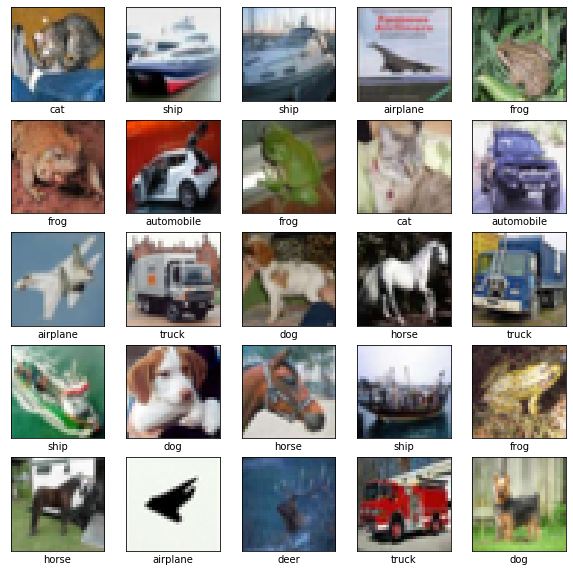

In [10]:
# Show pre labled exampels
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test_visual[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(cifar10_labels[y_test_visual[i][0]])
plt.show()

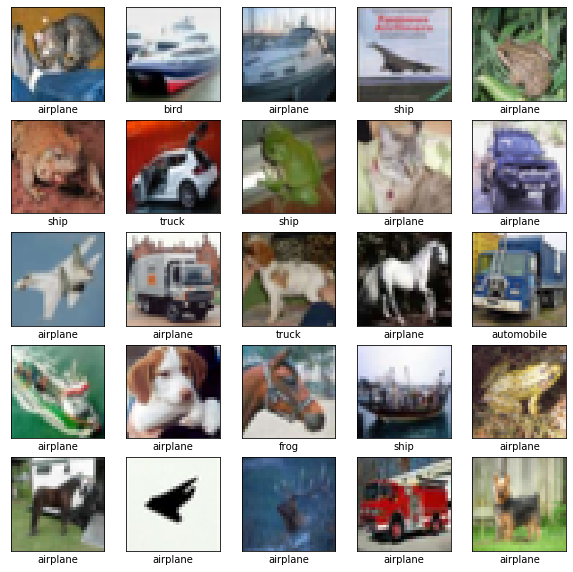

In [29]:
# Show predicted lables 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test_visual[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(cifar10_labels[y_test_pred_results[i][0]])
plt.show()